In [142]:
import pandas as pd
import numpy as np

seed = 0

In [143]:
!pip install pyscipopt seaborn


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [144]:
from math import ceil, floor

class Params:
    def __init__(self, var_idx: int, x_i: float, node_depth: int, nr_variables: int, curr_obj: float,
                 downgain: float, upgain: float, n_branches_by_var: int, n_nodes: int, downfrac: float, upfrac: float, obj_increases: list):
        self.var_idx = var_idx
        self.x_i = x_i
        self.node_depth = node_depth
        self.nr_variables = nr_variables
        self.curr_obj = curr_obj
        self.downgain = downgain
        self.upgain = upgain
        self.n_branches_by_var = n_branches_by_var
        self.n_nodes = n_nodes
        self.down_frac = downfrac
        self.up_frac = upfrac
        self.obj_increases = obj_increases


def __static_feat(i: int, A: np.ndarray, b: np.ndarray, c: np.ndarray):
    features = {}
    # 1st class
    # sign{c_i}
    c_i = c[i]
    features['sign'] = np.sign(c_i)

    # |c_i| / sum_{k: c_k >= 0} |c_k|
    pos_sum = np.sum(np.abs(c[c >= 0]))
    # |c_i| / sum_{k: c_k < 0} |c_k|
    neg_sum = np.sum(np.abs(c[c < 0]))

    features['c_i/sum_pos'] = abs(c_i) / pos_sum if pos_sum != 0 else 0
    features['c_i/sum_neg'] = abs(c_i) / neg_sum if neg_sum != 0 else 0

    # 2nd class
    # m_j^{+1}(i) = A_{ji}/|b_j|, forall j s.t. b_j >= 0
    M1_pos = []
    # m_j^{-1}(i) = A_{ji}/|b_j|, forall j s.t. b_j < 0
    M1_neg = []
    for j in range(A.shape[0]):
        a_ji = A[j, i]
        if b[j] >= 0:
            M1_pos.append(a_ji / abs(b[j]) if b[j] != 0 else 0)
        else:
            M1_neg.append(a_ji / abs(b[j]))

    features['M1_pos_min'] = np.min(M1_pos) if M1_pos else 0
    features['M1_pos_max'] = np.max(M1_pos) if M1_pos else 0
    features['M1_neg_min'] = np.min(M1_neg) if M1_neg else 0
    features['M1_neg_max'] = np.max(M1_neg) if M1_neg else 0

    # m_j^{2+} (i) = |c_i|/|A_{ji}| forall j s.t. c_i >= 0
    M2_pos = []
    # m_j^{2-} (i) = |c_i|/|A_{ji}| forall j s.t. c_i < 0
    M2_neg = []
    for j in range(A.shape[0]):
        if c[i] >= 0:
            M2_pos.append(abs(c_i) / abs(A[j, i]) if A[j, i] != 0 else 0)
        else:
            M2_neg.append(abs(c_i) / abs(A[j, i]) if A[j, i] != 0 else 0)

    features['M2_pos_min'] = np.min(M2_pos) if M2_pos else 0
    features['M2_pos_max'] = np.max(M2_pos) if M2_pos else 0
    features['M2_neg_min'] = np.min(M2_neg) if M2_neg else 0
    features['M2_neg_max'] = np.max(M2_neg) if M2_neg else 0

    M3_pp = []
    M3_pm = []
    M3_mp = []
    M3_mm = []

    for j in range(A.shape[0]):
        pos_sum = np.sum(np.abs(A[j, A[j] >= 0]))
        neg_sum = np.sum(np.abs(A[j, A[j] < 0]))

        a_ji = abs(A[j, i])
        if A[j, i] >= 0:
            M3_pp.append(a_ji / pos_sum if pos_sum != 0 else 0)
            M3_pm.append(a_ji / neg_sum if neg_sum != 0 else 0)
        else:
            M3_mp.append(a_ji / pos_sum if pos_sum != 0 else 0)
            M3_mm.append(a_ji / neg_sum if neg_sum != 0 else 0)

    features['M3_pp_min'] = np.min(M3_pp) if M3_pp else 0
    features['M3_pp_max'] = np.max(M3_pp) if M3_pp else 0
    features['M3_pm_min'] = np.min(M3_pm) if M3_pm else 0
    features['M3_pm_max'] = np.max(M3_pm) if M3_pm else 0
    features['M3_mp_min'] = np.min(M3_mp) if M3_mp else 0
    features['M3_mp_max'] = np.max(M3_mp) if M3_mp else 0
    features['M3_mm_min'] = np.min(M3_mm) if M3_mm else 0
    features['M3_mm_max'] = np.max(M3_mm) if M3_mm else 0

    return features


def __dynamic_feat(params: Params):
    # proportion of fixed variables at the current solution
    # depth of current node/nr of integer variables
    features = {}
    features['depth'] = params.node_depth / params.nr_variables

    features['min_xi'] = min(params.x_i - floor(params.x_i), ceil(params.x_i) - params.x_i)

    features['log_down_driebeek'] = np.log(params.downgain) / params.curr_obj if params.downgain > 0 else 0
    features['log_up_driebeek'] = np.log(params.upgain) / params.curr_obj if params.upgain > 0 else 0
    features['log_down_up_driebeek'] = np.log(params.downgain + params.upgain) / params.curr_obj if ( params.downgain + params.upgain) > 0 else 0
    features['down_driebeek'] = params.downgain / params.curr_obj if params.curr_obj != 0 else 0
    features['up_driebeek'] = params.upgain / params.curr_obj if params.curr_obj != 0 else 0

    #features['down_frac'] = params.down_frac
    #features['up_frac'] = params.up_frac

    return features


def __dynamic_opt_feat(params: Params):
    features = {}
    features['branching_ratio'] = params.n_branches_by_var / params.n_nodes

    """
    features['min_obj_increase'] = np.min(params.obj_increases) if params.obj_increases else 0
    features['max_obj_increase'] = np.max(params.obj_increases) if params.obj_increases else 0
    features['avg_obj_increase'] = np.mean(params.obj_increases) if params.obj_increases else 0
    features['std_obj_increase'] = np.std(params.obj_increases) if params.obj_increases else 0
    # quartiles
    features['quartile_25_obj_increase'] = np.percentile(params.obj_increases, 25) if params.obj_increases else 0
    features['quartile_50_obj_increase'] = np.percentile(params.obj_increases, 50) if params.obj_increases else 0
    features['quartile_75_obj_increase'] = np.percentile(params.obj_increases, 75) if params.obj_increases else 0

    # divide all by curr_obj
    features['min_obj_increase'] /= params.curr_obj if params.curr_obj != 0 else 0
    features['max_obj_increase'] /= params.curr_obj if params.curr_obj != 0 else 0
    features['avg_obj_increase'] /= params.curr_obj if params.curr_obj != 0 else 0
    features['std_obj_increase'] /= params.curr_obj if params.curr_obj != 0 else 0
    features['quartile_25_obj_increase'] /= params.curr_obj if params.curr_obj != 0 else 0
    features['quartile_50_obj_increase'] /= params.curr_obj if params.curr_obj != 0 else 0
    features['quartile_75_obj_increase'] /= params.curr_obj if params.curr_obj != 0 else 0
    """
    return features


def compute_features(params: Params, A: np.ndarray, b: np.ndarray, c: np.ndarray):
    static = __static_feat(params.var_idx, A, b, c)
    dynamic = __dynamic_feat(params)
    dynamic_opt = __dynamic_opt_feat(params)

    return {**static, **dynamic, **dynamic_opt}


In [145]:
from pyscipopt import Model, Branchrule, Variable
from pyscipopt import SCIP_RESULT
import numpy as np
from collections import defaultdict
import pandas as pd

class StrongBranchingRule(Branchrule):
    def __init__(self, model, A, b, c, logged, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.model: Model = model
        self.dataset = pd.DataFrame()
        self.A = A
        self.b = b
        self.c = c
        self.logged = logged
        self.n_branches_by_var = defaultdict(int)

    def branchexeclp(self, allowaddcons):
        branch_cands, branch_cand_sols, branch_cand_fracs, ncands, npriocands, nimplcands = self.model.getLPBranchCands()

        # Initialise scores for each variable
        scores = [-self.model.infinity() for _ in range(npriocands)]
        down_bounds = [None for _ in range(npriocands)]
        up_bounds = [None for _ in range(npriocands)]

        # Initialise placeholder values
        num_nodes = self.model.getNNodes()
        lpobjval = self.model.getLPObjVal()
        lperror = False
        best_cand_idx = 0

        # Start strong branching and iterate over the branching candidates
        self.model.startStrongbranch()
        for i in range(npriocands):

            # Check the case that the variable has already been strong branched on at this node.
            # This case occurs when events happen in the node that should be handled immediately.
            # When processing the node again (because the event did not remove it), there's no need to duplicate work.
            if self.model.getVarStrongbranchNode(branch_cands[i]) == num_nodes:
                down, up, downvalid, upvalid, _, lastlpobjval = self.model.getVarStrongbranchLast(branch_cands[i])
                if downvalid:
                    down_bounds[i] = down
                if upvalid:
                    up_bounds[i] = up
                downgain = max([down - lastlpobjval, 0])
                upgain = max([up - lastlpobjval, 0])
                scores[i] = self.model.getBranchScoreMultiple(branch_cands[i], [downgain, upgain])
                continue

            # Strong branch
            down, up, downvalid, upvalid, downinf, upinf, downconflict, upconflict, lperror = self.model.getVarStrongbranch(
                branch_cands[i], 200, idempotent=False)

            # In the case of an LP error handle appropriately (for this example we just break the loop)
            if lperror:
                break

            # In the case of both infeasible sub-problems cutoff the node
            if downinf and upinf:
                return {"result": SCIP_RESULT.CUTOFF}

            # Calculate the gains for each up and down node that strong branching explored
            if not downinf and downvalid:
                down_bounds[i] = down
                downgain = max([down - lpobjval, 0])
            else:
                downgain = 0
            if not upinf and upvalid:
                up_bounds[i] = up
                upgain = max([up - lpobjval, 0])
            else:
                upgain = 0


            # Update the pseudo-costs
            lpsol = branch_cands[i].getLPSol()
            if not downinf and downvalid:
                self.model.updateVarPseudocost(branch_cands[i], -self.model.frac(lpsol), downgain, 1)
            if not upinf and upvalid:
                self.model.updateVarPseudocost(branch_cands[i], 1 - self.model.frac(lpsol), upgain, 1)

            scores[i] = self.model.getBranchScoreMultiple(branch_cands[i], [downgain, upgain])
            if scores[i] > scores[best_cand_idx]:
                best_cand_idx = i

            self.n_branches_by_var[branch_cands[i].name] += 1
            params = Params(
                var_idx=branch_cands[i].getCol().getLPPos(),
                x_i=branch_cands[i].getObj(),
                node_depth=self.model.getCurrentNode().getDepth(),
                nr_variables=self.model.getNVars(),
                curr_obj=self.model.getLPObjVal(),
                downgain=downgain,
                upgain=upgain,
                n_branches_by_var=self.n_branches_by_var[branch_cands[i].name],
                n_nodes=self.model.getNNodes(),
            )
            features = compute_features(params, self.A, self.b, self.c)
            curr_obj = self.model.getLPObjVal()
            features['score'] = scores[i] / np.abs(curr_obj) if curr_obj != 0 else 0
            row = pd.DataFrame.from_dict(features, orient='index').T
            self.dataset = pd.concat([self.dataset, row], ignore_index=True)

        # End strong branching
        self.model.endStrongbranch()

        # In the case of an LP error
        if lperror:
            return {"result": SCIP_RESULT.DIDNOTRUN}

        # print("--> Strong branching on variable:", branch_cands[best_cand_idx].name)
        # Branch on the variable with the largest score
        down_child, eq_child, up_child = self.model.branchVarVal(
            branch_cands[best_cand_idx], branch_cands[best_cand_idx].getLPSol())

        # Update the bounds of the down node and up node. Some cols might not exist due to pricing
        if self.model.allColsInLP():
            if down_child is not None and down_bounds[best_cand_idx] is not None:
                self.model.updateNodeLowerbound(down_child, down_bounds[best_cand_idx])
            if up_child is not None and up_bounds[best_cand_idx] is not None:
                self.model.updateNodeLowerbound(up_child, up_bounds[best_cand_idx])

        return {"result": SCIP_RESULT.BRANCHED}


In [146]:
from collections import defaultdict
from datetime import datetime
import numpy as np
from pyscipopt import Model, quicksum, SCIP_PARAMSETTING
from pyscipopt import Branchrule
from pyscipopt.scip import Term
from pyscipopt.scip import Solution

class Problem:
    def __init__(self, name, c, lb, ub, constraint_types, b, A, var_types=None, model=None):
        self.name = name
        self.c = c
        self.lb = lb
        self.ub = ub
        self.constraint_types = constraint_types
        self.var_types = var_types if var_types is not None else ['B'] * len(c)  # assuming binary
        self.b = b
        self.A = A

        self.model = model

    @staticmethod
    def from_model(path):
        model : Model = Model()
        model.readProblem(path)
        name = model.getProbName()

        variables = model.getVars()
        constraints = model.getConss()

        # Initialize data structures
        n_vars = len(variables)
        n_cons = len(constraints)

        # Create mapping from variable to index
        A_data = defaultdict(float)
        b = np.zeros(n_cons)
        c = np.zeros(n_vars)

        # Extract objective coefficients (vector c)
        for i, var in enumerate(variables):
            c[i] = model.getObjective().terms.get(Term(var), 0.0)

        variables = model.getVars()
        var_names = [v.name for v in variables]
        num_vars = len(variables)

        # Initialize A and b
        A = []
        b = []
        constraint_senses = []

        all_constraints = model.getConss()

        for con in all_constraints:
            assert con.isLinear(), "Only linear constraints are supported"

            # Get coefficients for this linear constraint
            coeffs = model.getValsLinear(con)

            # Create a row for the A matrix
            row = [0.0] * num_vars
            for var, coeff in coeffs.items():
                v = list(filter(lambda x: x.name == var, model.getVars()))[0]
                try:
                    # Find the index of the variable in our ordered list
                    var_index = v.getIndex()
                    row[var_index] = coeff
                except ValueError:
                    # This case should ideally not happen if getVars() gets all relevant variables,
                    # but it's good practice to handle unexpected variables.
                    print(f"Warning: Variable {var.getName()} found in constraint {con.getName()} but not in model's getVars() list.")
                    pass

            rhs = model.getRhs(con)
            A.append(row)
            b.append(rhs)

        A = np.array(A)
        b = np.array(b)
        return Problem(name, c=c, lb=[], ub=[], constraint_types=[], b=b, A=A, var_types=[], model=model)

    def solve_with_sb(self, logged=False):
        model = self.__build_model() if self.model is None else self.model

        if not logged:
            model.hideOutput()
            model.setIntParam('display/verblevel', 0)  # Quiet mode
        else:
            model.setIntParam('display/verblevel', 3)  # Verbose output

        sb = StrongBranchingRule(model, self.A, self.b, self.c, logged)

        model.includeBranchrule(
            sb,
            "strongbranching",
            "Custom strong branching rule for learning",
            priority=1000000,  # High priority to ensure it's used
            maxdepth=-1,  # No depth limit
            maxbounddist=1.0
        )
        model.writeProblem(f"{self.name}_sb.lp")

        start = datetime.now()
        model.optimize()
        end = datetime.now()

        assert model.getStatus() == "optimal", f"Model {model.getProbName()} did not solve to optimality. Status: {model.getStatus()}"

        stats = {
            'time': (end - start).total_seconds(),
            'n_vars': len(self.c),
            'n_constraints': len(self.b),
            'name': self.name,
            'sb_decision': sb.model.getNNodes(),
            'gap': sb.model.getGap(),
        }
        return sb.dataset, stats

    def solve_with_learned_sb(self, predictor, logged=False, max_nodes=-1, timelimit=-1):
        model = self.__build_model() if self.model is None else self.model

        if not logged:
            model.hideOutput()
            model.setIntParam('display/verblevel', 0)  # Quiet mode
        else:
            model.setIntParam('display/verblevel', 3)  # Verbose output

        if max_nodes > 0:
            model.setIntParam('limits/nodes', max_nodes)

        if timelimit > 0:
            model.setRealParam('limits/time', timelimit)

        sb = LearnedStrongBranching(model, predictor, self.A, self.b, self.c, logged)

        model.includeBranchrule(
            sb,
            "learnedstrongbranching",
            "Custom learned strong branching rule",
            priority=1000000,  # High priority to ensure it's used
            maxdepth=-1,
            maxbounddist=1.0
        )

        start = datetime.now()
        model.optimize()
        end = datetime.now()

        assert model.getStatus() == "optimal", f"Model {model.getProbName()} did not solve to optimality. Status: {model.getStatus()}"

        stats = {
            'time': (end - start).total_seconds(),
            'name': self.name,
            'sb_decision': sb.model.getNNodes(),
            'gap': sb.model.getGap(),
        }
        return stats

    def solve_with(self, logged=False, max_nodes=-1, timelimit=-1):
        model = self.__build_model() if self.model is None else self.model

        if not logged:
            model.hideOutput()
            model.setIntParam('display/verblevel', 0)  # Quiet mode
        else:
            model.setIntParam('display/verblevel', 3)  # Verbose output

        if max_nodes > 0:
            model.setIntParam('limits/nodes', max_nodes)

        if timelimit > 0:
            model.setRealParam('limits/time', timelimit)

        model.includeBranchrule(
            sb,
            "learnedstrongbranching",
            "Custom learned strong branching rule",
            priority=1000000,  # High priority to ensure it's used
            maxdepth=-1,
            maxbounddist=1.0
        )

        start = datetime.now()
        model.optimize()
        end = datetime.now()

        assert model.getStatus() == "optimal", f"Model {model.getProbName()} did not solve to optimality. Status: {model.getStatus()}"

        stats = {
            'time': (end - start).total_seconds(),
            'name': self.name,
            'sb_decision': sb.model.getNNodes(),
            'gap': sb.model.getGap(),
        }
        return stats


    def __build_model(self):
        model = Model(self.name)
        n_vars = len(self.c)
        x = []
        for i in range(n_vars):
            if self.var_types[i] == 'B':
                x.append(model.addVar(name=f"x_{i}", vtype="B"))
            elif self.var_types[i] == 'C':
                x.append(model.addVar(name=f"x_{i}", vtype="C", lb=self.lb[i], ub=self.ub[i]))

        # Set objective function
        model.setObjective(quicksum(self.c[i] * x[i] for i in range(n_vars)), "minimize")

        n_constraints = len(self.b)
        if n_constraints != len(self.constraint_types):
            raise Exception(
                f"Number of constraints ({n_constraints}) doesn't match number of types ({len(self.constraint_types)})")

        # Add constraints
        for i in range(n_constraints):
            lhs = quicksum(self.A[i][j] * x[j] for j in range(n_vars) if self.A[i][j] != 0)

            if self.constraint_types[i] == 'E':
                model.addCons(lhs == self.b[i])
            elif self.constraint_types[i] == 'G':
                model.addCons(lhs >= self.b[i])
            elif self.constraint_types[i] == 'L':
                model.addCons(lhs <= self.b[i])

        # Disable cuts
        model.setIntParam('separating/maxrounds', 0)
        model.setIntParam('separating/maxroundsroot', 0)
        model.setParam("separating/maxcuts", 0)
        model.setParam("separating/maxcutsroot", 0)
        model.setParam("separating/maxrounds", 0)
        model.setParam("separating/maxroundsroot", 0)

        # Disable various cutting plane methods
        cut_types = [
            'separating/clique', 'separating/gomory', 'separating/strongcg',
            'separating/cmir', 'separating/flowcover', 'separating/mcf', 'separating/zerohalf',
        ]
        for cut_type in cut_types:
            model.setIntParam(f'{cut_type}/freq', -1)

        # Disable heuristics
        model.setIntParam('heuristics/dps/freq', -1)

        # Disable presolving
        model.setBoolParam('lp/presolving', False)
        model.setBoolParam('concurrent/presolvebefore', False)
        model.setBoolParam('presolving/donotmultaggr', True)

        presolving = [
            "presolving/maxrounds",
            "presolving/trivial/maxrounds",
            "presolving/inttobinary/maxrounds",
            "presolving/gateextraction/maxrounds",
            "presolving/dualcomp/maxrounds",
            "presolving/domcol/maxrounds",
            "presolving/implics/maxrounds",
            "presolving/sparsify/maxrounds",
            "presolving/dualsparsify/maxrounds",
            "propagating/dualfix/maxprerounds",
            "propagating/genvbounds/maxprerounds",
            "propagating/obbt/maxprerounds",
            "propagating/nlobbt/maxprerounds",
            "propagating/probing/maxprerounds",
            "propagating/pseudoobj/maxprerounds",
            "propagating/redcost/maxprerounds",
            "propagating/rootredcost/maxprerounds",
            "propagating/symmetry/maxprerounds",
            "propagating/vbounds/maxprerounds",
            "propagating/maxrounds",
            "propagating/maxroundsroot",
            "constraints/cardinality/maxprerounds",
            "constraints/SOS1/maxprerounds",
            "constraints/SOS2/maxprerounds",
            "constraints/varbound/maxprerounds",
            "constraints/knapsack/maxprerounds",
            "constraints/setppc/maxprerounds",
            "constraints/linking/maxprerounds",
            "constraints/or/maxprerounds",
            "constraints/and/maxprerounds",
            "constraints/xor/maxprerounds",
            "constraints/conjunction/maxprerounds",
            "constraints/disjunction/maxprerounds",
            "constraints/linear/maxprerounds",
            "constraints/orbisack/maxprerounds",
            "constraints/orbitope/maxprerounds",
            "constraints/symresack/maxprerounds",
            "constraints/logicor/maxprerounds",
            "constraints/bounddisjunction/maxprerounds",
            "constraints/cumulative/maxprerounds",
            "constraints/nonlinear/maxprerounds",
            "constraints/pseudoboolean/maxprerounds",
            "constraints/superindicator/maxprerounds",
            "constraints/indicator/maxprerounds",
            "constraints/components/maxprerounds",
            "presolving/maxrestarts",
            "presolving/maxrounds",
        ]

        for presolve in presolving:
            model.setIntParam(presolve, 0)

        model.setIntParam('display/freq', 500)
        model.setHeuristics(SCIP_PARAMSETTING.OFF)
        model.setSeparating(SCIP_PARAMSETTING.OFF)


        assert(model.getNConss() == len(self.A)), "Number of constraints in model doesn't match number of constraints in problem"
        assert(model.getNConss() == len(self.b)), "Number of constraints in model doesn't match number of constraints in problem"
        assert(model.getNVars() == len(self.c)), "Number of variables in model doesn't match number of variables in problem"
        return model

    def __repr__(self):
        return f"Problem(name={self.name})"

In [147]:
import numpy as np

"""
Formulation
min k = sum_{j in J} y_j
s.t.
     k >= 1
     sum_{i in I} s(i) x_{ij} <= B y_i forall j in J
     sum_{j in J} x_{ij} = 1 forall i in I

     y_j in {0,1} forall j in J
     x_{ij} in {0,1} forall i in I, j in J

     x_{ij} in {0,1} forall i in I, j in J
     y_j in {0,1} forall j in J

     I: items, J: bins
     s(i): size of item i
     B: bin capacity
"""


def bin_packing(n_problems: int, items: (int, int), bins: (int, int), bin_capacity: (float, float),
                item_size: (float, float)):
    return [__generate_bp(i, items, bins, bin_capacity, item_size) for i in range(n_problems)]


def __generate_bp(id: int, items: (int, int), bins: (int, int), bin_capacity: (float, float),
                       item_size: (float, float)):
    n_items = np.random.randint(*items)
    n_bins = np.random.randint(*bins)
    bin_capacity = np.random.uniform(*bin_capacity)
    item_sizes = np.random.uniform(*item_size, size=n_items)
    n_vars = n_bins + n_items * n_bins  # y_i + x_{ij}
    assert n_vars < 1000, "Community edition has a limit of 1000 variables"

    c = np.concatenate([
        np.ones(n_bins),  # cost for bins (y_j)
        np.zeros(n_items * n_bins)  # no cost for x_{ij} (multiplying n_items * n_bins as x has 2 indexes)
    ])

    A, b, types = [], [], []

    ## constraints
    # k >= 1
    A.append(np.concatenate([np.zeros(n_bins), np.ones(n_items * n_bins)]))
    b.append(1)
    types.append('G')

    # sum(s(i) * x_ij) <= B * y_j for all j
    for j in range(n_bins):
        row = np.zeros(n_vars)
        row[j] = -bin_capacity  # coefficient for y_j
        for i in range(n_items):
            row[n_bins + i * n_bins + j] = item_sizes[i]  # coefficient for x_{ij}
        A.append(row)
        b.append(0)
        types.append('L')

    # sum(x_ij) = 1 for all i
    for i in range(n_items):
        row = np.zeros(n_vars)
        for j in range(n_bins):
            row[n_bins + i * n_bins + j] = 1  # coefficient for x_{ij}
        A.append(row)
        b.append(1)
        types.append('E')

    A = np.array(A)
    b = np.array(b)
    assert A.shape[0] == b.shape[0], "A and b must have the same number of rows"
    assert b.shape[0] <= 1000, "Community edition has a limit of 1000 constraints"

    types = np.array(types)

    return Problem(
        name=f"random_BP_{id}",
        c=c,
        lb=[0] * n_vars,
        ub=[1] * n_vars,
        constraint_types=types,
        b=b,
        A=A
    )


In [148]:
import numpy as np

"""
Formulation
min sum_{s in S} x_s
s.t. sum_{s: e in s} x_s >= 1 forall e in E
x in {0,1}^n
"""

A_DENSITY = 0.3


def set_cover(n_problems: int, universe_size_range=(50, 70)):
    return [__generate_sc(i, universe_size_range) for i in range(n_problems)]

def __generate_sc(id: int, universe_size_range):
    # universe selection
    universe_size = np.random.randint(*universe_size_range)
    universe = np.random.choice(list(range(1, 100)), size=universe_size, replace=False)

    binary_matrix = np.random.randint(0, 2, size=(len(universe), len(universe)))

    # Ensure each row and column has at least one 1 to avoid empty sets
    for i in range(binary_matrix.shape[0]):
        if np.sum(binary_matrix[i, :]) == 0:
            binary_matrix[i, np.random.randint(0, binary_matrix.shape[1])] = 1

    for j in range(binary_matrix.shape[1]):
        if np.sum(binary_matrix[:, j]) == 0:
            binary_matrix[np.random.randint(0, binary_matrix.shape[0]), j] = 1

    # mapping to universe elements
    subsets = []
    for j in range(binary_matrix.shape[1]):
        subset = []
        for i in range(binary_matrix.shape[0]):
            if binary_matrix[i, j] == 1:
                subset.append(universe[i])
        subsets.append(subset)

    # remove duplicated sets from subsets
    unique_subsets = []
    for subset in subsets:
        if subset not in unique_subsets:
            unique_subsets.append(subset)

    # shuffling within subsets
    for i in range(len(unique_subsets)):
        np.random.shuffle(unique_subsets[i])

    # Create Problem object
    n_subsets = len(unique_subsets)
    n_elements = len(universe)

    A = np.zeros((n_elements, len(unique_subsets)))
    for j, subset in enumerate(unique_subsets):
        for elem in subset:
            i, = np.where(universe == elem)
            A[i, j] = 1

    c = np.ones(len(unique_subsets))
    b = np.ones(n_elements)
    types = ['G'] * n_elements

    return Problem(
        name=f"SC_{id}",
        c=c,
        lb=[0] * n_subsets,
        ub=[1] * n_subsets,
        constraint_types=types,
        b=b,
        A=A,
    )


In [149]:
from tqdm import tqdm
bp_instances, sc_instances = 60, 60

np.random.seed = 42

dataset = {}

dataset['BP'] = bin_packing(
    n_problems=bp_instances,
    items=(10, 20),
    bins=(5, 10),
    bin_capacity=(0.5, 1.5),
    item_size=(0.1, 0.9),
)

dataset['SC'] = set_cover(
    n_problems=sc_instances,
    universe_size_range=(50, 80),
)

# split in train and test (80% train, 20% test)
for name, problems in dataset.items():
    n_train = int(len(problems) * 0.8)
    np.random.shuffle(problems)
    dataset[name] = {
        'train': problems[:n_train],
        'test': problems[n_train:]
    }

In [150]:
import os

current_dir = '/kaggle/working'

def solve(problems, name):
    if len(problems) == 0:
        return

    dataset_name = f"{current_dir}/{name}_solution.csv"
    stats_name = f"{current_dir}/{name}_stats.csv"

    dataset = pd.read_csv(dataset_name) if os.path.exists(dataset_name) else pd.DataFrame()
    stats = pd.read_csv(stats_name) if os.path.exists(stats_name) else pd.DataFrame()

    for problem in tqdm(problems, desc=f"Solving problems {name}", unit="problem"):
        try:
            names = stats['name'].values if stats.get('name', None) is not None else []
            if not problem.name in names:
                solution, stats_result = problem.solve_with_sb(logged=False)
                dataset = pd.concat([dataset, solution], ignore_index=True)
                stats_row = pd.DataFrame.from_dict(stats_result, orient='index').T
                stats = pd.concat([stats, stats_row], ignore_index=True)
                print(f"Problem {problem.name} solved in {stats_result['time']} seconds")
                # overwrite dataset and stats files
                dataset.to_csv(f"{current_dir}/{name}_solution.csv")
                stats.to_csv(f"{current_dir}/{name}_stats.csv")
            else:
                print(f"Problem {problem.name} already solved, skipping.")
        except AssertionError as e:
            print(f"Problem has no solution: {problem.name}")
        except Exception as e:
            print(f"Error solving problem {problem.name}: {e}")
            continue


In [ ]:
import kagglehub, os

binpacking_setcover_path = kagglehub.dataset_download('elenaferr0/testpkl')
dataset_files = [
    f"{binpacking_setcover_path}/BP_train_solution.pkl",
    f"{binpacking_setcover_path}/BP_test_solution.pkl",
    f"{binpacking_setcover_path}/SC_train_solution.pkl",
    f"{binpacking_setcover_path}/SC_test_solution.pkl"
]

all_generated = True # skip problem resolution if files exist
for f in dataset_files:
    if not os.path.isfile(f):
        all_generated = False

if not all_generated:
    for name, problems in dataset.items():
        print(f"Solving {name} problems")
        solve(problems['train'], f"{name}_train")
        print(f"Solving {name} test problems")
        solve(problems['test'], f"{name}_test")

## Dataset loading (read generated csv files)

In [73]:
import pandas as pd

binpacking_setcover_path = 'dataset/exported/'
BP_train = pd.read_pickle(f"{binpacking_setcover_path}/BP_train_solution.pkl")
BP_test = pd.read_pickle(f"{binpacking_setcover_path}/BP_test_solution.pkl")
SC_train = pd.read_pickle(f"{binpacking_setcover_path}/SC_train_solution.pkl")
SC_test = pd.read_pickle(f"{binpacking_setcover_path}/SC_test_solution.pkl")

train = pd.concat([BP_train, SC_train], ignore_index=True)
train = train.sample(frac=0.2, random_state=seed)
test = pd.concat([BP_test, SC_test], ignore_index=True)
test = test.sample(frac=0.2, random_state=seed)
print(f"Train set size: {train.shape}")
print(f"Test set size: {test.shape}")

X_train = train.drop(columns=['score'])
Y_train = np.log(train['score'])

X_test = test.drop(columns=['score'])
Y_test = np.log(test['score'])

Train set size: (57746, 37)
Test set size: (8101, 37)


In [74]:
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.preprocessing import StandardScaler

def create_pipeline(predictor):
  return Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('feature_selection', SelectKBest(f_regression, k=10)),
    ('predictor', predictor)
  ])

## Preprocessing

### PCA

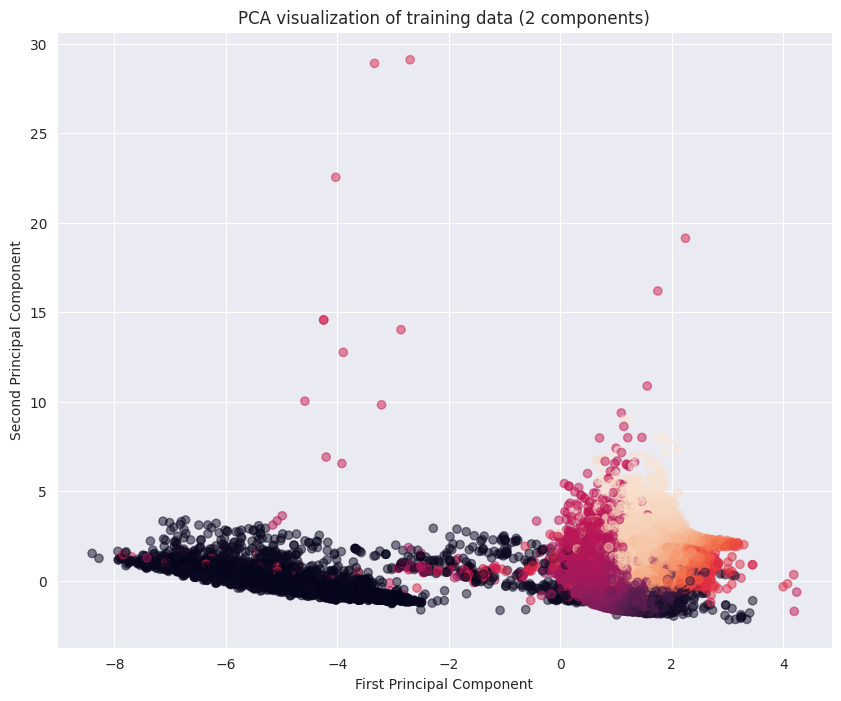

In [152]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# First PCA visualization
pipeline = create_pipeline(PCA(n_components=2))
x_pca = pipeline.fit_transform(X_train, Y_train)

plt.figure(figsize=(10, 8))
plt.title('PCA visualization of training data (2 components)')
plt.scatter(x_pca[:, 0], x_pca[:, 1], c=Y_train, alpha=0.5)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.show()

In [153]:
import seaborn as sns
import string, itertools

double_letter = [''.join(combo) for combo in itertools.product(string.ascii_uppercase, repeat=2)]
def label_results(results_df):
    identifiers = double_letter[:results_df.shape[0]]
    results_df['config_id'] = identifiers
    return results_df

def plot_results(results_df):
  results_df['pos_mse'] = results_df['mean_test_score'].abs()

  plt.figure(figsize=(10, 6))
  ax = sns.scatterplot(data=results_df, x='mean_fit_time', y='pos_mse')
  plt.title('Mean Fit Time vs. MSE')
  plt.xlabel('Mean Fit Time (s)')
  plt.ylabel('Mean Squared Error (MSE)')

  plt.grid(True, linestyle='--', alpha=0.6)

  for i in range(results_df.shape[0]):
      x = results_df['mean_fit_time'].iloc[i]
      y = results_df['pos_mse'].iloc[i]
      label = results_df['config_id'].iloc[i]
      ax.annotate(str(label), (x, y), textcoords="offset points", xytext=(10,10), ha='left', fontsize=12)

  legend_text = "Configurations:\n"
  for i in range(results_df.shape[0]):
      legend_text += f"{results_df['config_id'].iloc[i]}: {results_df['params'].iloc[i]}\n"

  fig = plt.gcf()
  fig.text(1.02, 0.95, legend_text, transform=ax.transAxes, fontsize=9, verticalalignment='top')

  fig.subplots_adjust(right=0.7)

  plt.tight_layout()
  plt.show()

In [155]:
def pick_best_mse_fit_time_tradeoff(cv_results):
    results_df = pd.DataFrame(cv_results)
    results_df = label_results(results_df)
    plot_results(results_df)

    col1, col2 = 'mean_fit_time', 'mean_test_score'
    return []


In [156]:
from sklearn.metrics import r2_score, mean_squared_error, max_error, mean_absolute_error, root_mean_squared_error
import pandas as pd

metrics = pd.DataFrame()
def print_metrics(model, X_test, Y_test, name):
  global metrics

  y_pred = model.predict(X_test)
  r2 = r2_score(Y_test, y_pred)
  mse = mean_squared_error(Y_test, y_pred)
  rmse = root_mean_squared_error(Y_test, y_pred)
  mape = mean_absolute_percentage_error(Y_test, y_pred)
  me = max_error(Y_test, y_pred)

  print(f"Test set evaluation metrics for {name}")
  print(f"Test set R² score: {r2:.4f}")
  print(f"Test set MSE: {mse:.4f}")
  print(f"Test set MAPE: {mape:.4f}")
  print(f"Test set RMSE: {rmse:.4f}")
  print(f"Test set Max error: {me:.4f}")

  row = pd.Series({'name': name, 'r2': r2, 'mse': mse, 'mape': mape, 'max_err': me })
  metrics = pd.concat([metrics, row.to_frame().T], ignore_index=True)


## Extra Trees Regressor

In [158]:
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import GridSearchCV
import numpy as np

params = {
    "predictor__n_estimators": [2, 3, 4, 5, 10],
    "predictor__min_samples_leaf": [10, 15, 20],
    "predictor__max_depth": [2, 3, 5, 7],
}
et = ExtraTreesRegressor(random_state=seed)
ert_pipeline = create_pipeline(et)

gs = GridSearchCV(ert_pipeline, param_grid=params, cv=5, scoring='neg_mean_squared_error', verbose=1)
gs.fit(X_train, Y_train)

print("Best score: ", gs.best_score_)
print("Best params: ", gs.best_params_)

# 10 10
print_metrics(gs.best_estimator_, X_test, Y_test, 'ExtraTreeRegressor')
pick_best_mse_fit_time_tradeoff(gs.cv_results_)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
Best score:  -0.40131867093510715
Best params:  {'predictor__max_depth': 7, 'predictor__min_samples_leaf': 10, 'predictor__n_estimators': 10}
Test set evaluation metrics for ExtraTreeRegressor
Test set R² score: 0.9877
Test set MSE: 0.5980
Test set MAPE: 0.0296
Test set RMSE: 0.7733
Test set Max error: 11.7659


## Single decision tree regressor

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best score:  -0.012658791765212766
Best params:  {'predictor__max_depth': 10, 'predictor__min_samples_leaf': 7}
Test set evaluation metrics for DecisionTreeRegressor
Test set R² score: 0.9991
Test set MSE: 0.0425
Test set MAPE: 0.0031
Test set RMSE: 0.2061
Test set Max error: 12.3287


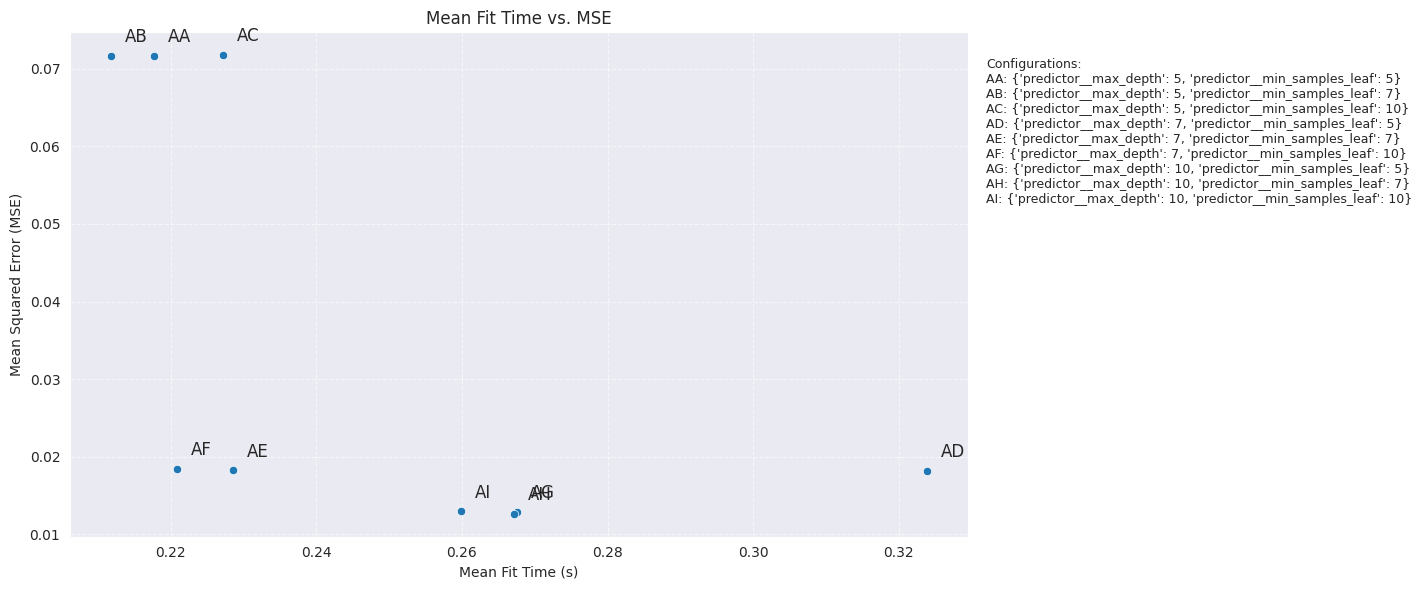

[]

In [160]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

params = {
    "predictor__min_samples_leaf": [5, 7, 10],
    "predictor__max_depth": [5, 7, 10],
}

dt = DecisionTreeRegressor(random_state=seed)
dt_pipeline = create_pipeline(dt)

gs = GridSearchCV(dt_pipeline, param_grid=params, cv=5, scoring='neg_mean_squared_error', verbose=1)
gs.fit(X_train, Y_train)

print("Best score: ", gs.best_score_)
print("Best params: ", gs.best_params_)

# 10 10
print_metrics(gs.best_estimator_, X_test, Y_test, 'DecisionTreeRegressor')
pick_best_mse_fit_time_tradeoff(gs.cv_results_)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
Best score:  -2.3524097577334273
Best params:  {'predictor__alpha': 0.05}
Test set evaluation metrics for Lasso
Test set R² score: 0.9429
Test set MSE: 2.7837
Test set MAPE: 0.0900
Test set RMSE: 1.6685
Test set Max error: 19.5634


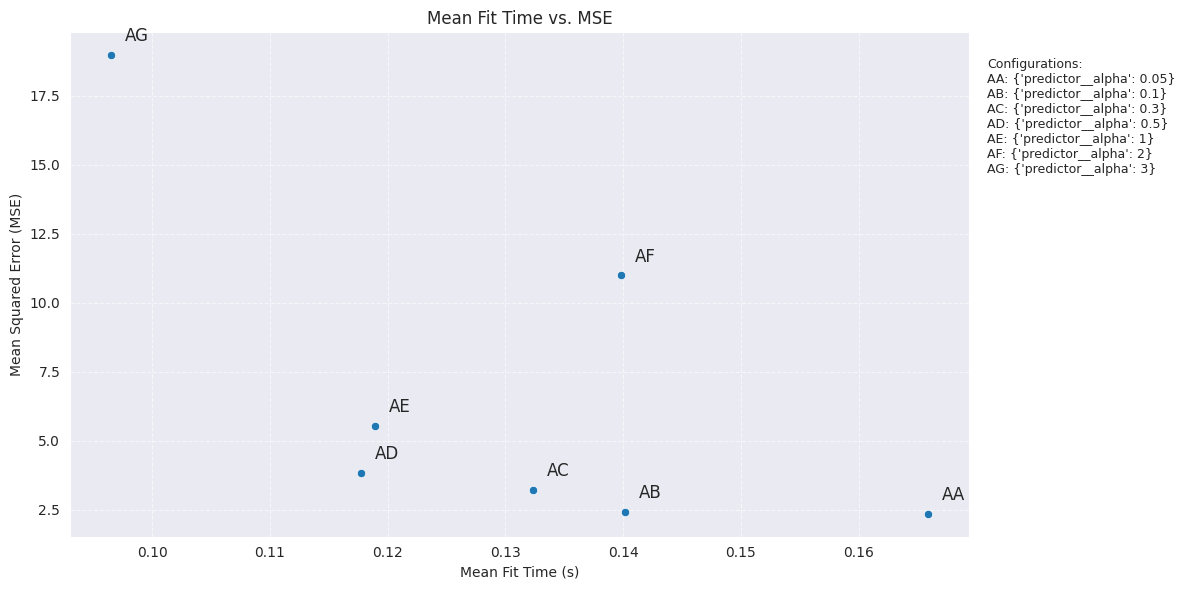

[]

In [161]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso

params = {
    'predictor__alpha': [0.05, 0.1, 0.3, 0.5, 1, 2, 3]
}

lasso_pipeline = create_pipeline(Lasso(random_state=seed))
gs = GridSearchCV(lasso_pipeline, param_grid=params, cv=5, scoring='neg_mean_squared_error', verbose=1)
gs.fit(X_train, Y_train)

print("Best score: ", gs.best_score_)
print("Best params: ", gs.best_params_)

print_metrics(gs.best_estimator_, X_test, Y_test, 'Lasso')
pick_best_mse_fit_time_tradeoff(gs.cv_results_)

In [162]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LinearRegression

lr_pipeline = create_pipeline(LinearRegression())
scores = cross_validate(lr_pipeline, X_train, Y_train, cv=5, scoring='neg_mean_squared_error')
print(scores)

{'fit_time': array([0.05835366, 0.06753707, 0.06750703, 0.05860353, 0.06273007]), 'score_time': array([0.00479102, 0.00502682, 0.0067904 , 0.00556016, 0.00613189]), 'test_score': array([-2.26318688, -2.2268781 , -2.24516469, -2.35592943, -2.20917381])}


# imodels rules

In [163]:
!pip install imodels


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [164]:
from imodels import GreedyTreeRegressor

params = {
    'predictor__min_samples_leaf': [5, 10, 20, 50],
    'predictor__max_depth': [2, 3, 5, 10],
    'predictor__max_features': [None, 'sqrt']
}

gtr_pipeline = create_pipeline(GreedyTreeRegressor(random_state=seed))
gs = GridSearchCV(gtr_pipeline, param_grid=params, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=1)
gs.fit(X_train, Y_train)

print("Best score: ", gs.best_score_)
print("Best params: ", gs.best_params_)

print_metrics(gs.best_estimator_, X_test, Y_test, 'GreedyTreeRegressor')

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best score:  -0.02072140608003658
Best params:  {'predictor__max_depth': 10, 'predictor__max_features': None, 'predictor__min_samples_leaf': 5}
Test set evaluation metrics for GreedyTreeRegressor
Test set R² score: 0.9991
Test set MSE: 0.0429
Test set MAPE: 0.0032
Test set RMSE: 0.2072
Test set Max error: 12.3287


In [165]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error, max_error

params = {
    'predictor__min_samples_leaf': [5, 10, 20],
    'predictor__max_depth': [2, 5, 10],
    'predictor__max_features': ['sqrt', None]
}

brr_pipeline = create_pipeline(GreedyTreeRegressor())
gs = GridSearchCV(brr_pipeline, param_grid=params, cv=5, scoring='neg_mean_absolute_error',  n_jobs=-1, verbose=1)
gs.fit(X_train, Y_train)

print("Best score: ", gs.best_score_)
print("Best params: ", gs.best_params_)

print_metrics(gs.best_estimator_, X_test, Y_test, 'BoostedRulesRegressor')


Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best score:  -0.020727740909688368
Best params:  {'predictor__max_depth': 10, 'predictor__max_features': None, 'predictor__min_samples_leaf': 5}
Test set evaluation metrics for BoostedRulesRegressor
Test set R² score: 0.9991
Test set MSE: 0.0429
Test set MAPE: 0.0032
Test set RMSE: 0.2072
Test set Max error: 12.3287


['r2', 'mse', 'mape', 'max_err']


ValueError: Could not interpret value `name` for `x`. An entry with this name does not appear in `data`.

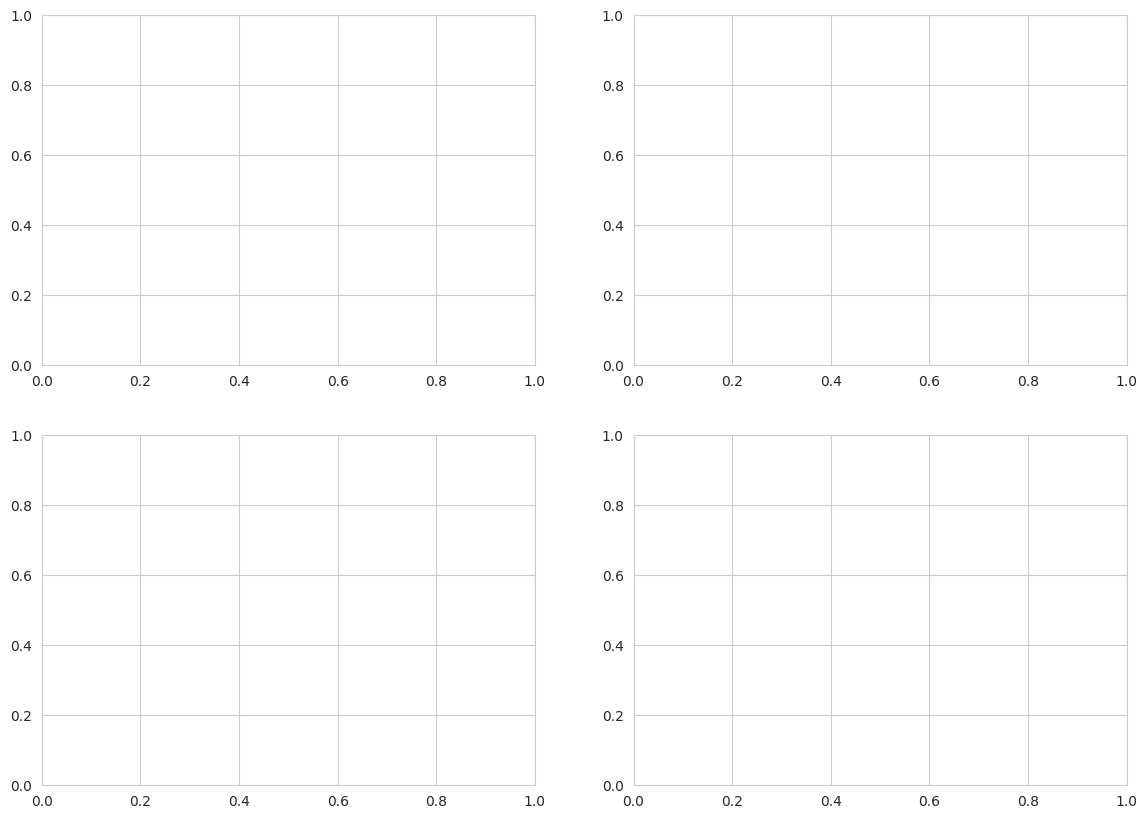

In [174]:
print(metrics)
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()  # Flatten the 2x2 array to make it easier to iterate

# Set a style
sns.set_style("whitegrid")

# Colors for the bars
colors = ['#3498db', '#2ecc71', '#e74c3c', '#f39c12']

# Create a bar chart for each metric
metric_names = ['r2', 'mse', 'mape', 'max_err']
titles = ['R² Score (higher is better)', 'Mean Squared Error (lower is better)',
          'Mean Absolute Percentage Error (lower is better)', 'Maximum Error (lower is better)']

for i, (metric, title, color) in enumerate(zip(metric_names, titles, colors)):
    ax = axes[i]

    # Create the bar chart
    bars = sns.barplot(x='name', y=metric, data=metrics_df, ax=ax, palette=[color])

    # Add value labels on top of the bars
    for bar in bars.patches:
        # Get the height of the bar
        height = bar.get_height()

        # Format the text to show on the bar
        # Use scientific notation for very small numbers
        if height < 0.01:
            text = f"{height:.2e}"
        else:
            text = f"{height:.6f}"

        # Add the text above the bar
        ax.text(
            bar.get_x() + bar.get_width()/2., height+0.0001,
            text,
            ha='center', va='bottom', fontsize=10, rotation=0
        )

    # Set the title and labels
    ax.set_title(title, fontsize=12, pad=10)
    ax.set_xlabel('')
    ax.set_ylabel(metric.upper(), fontsize=11)

    # Adjust y-axis limits to make the bars more visible
    # For R² which should be close to 1, set the minimum to a reasonable value
    if metric == 'r2':
        ax.set_ylim([0.9, 1.0])

    # For small values (like mape), adjust to make them visible
    if metric == 'mape':
        ax.set_ylim([0, 0.01])

    # Customize the x-axis to show the model name clearly
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

# Adjust the layout
plt.tight_layout()
plt.subplots_adjust(hspace=0.3)

# Show the plot
plt.suptitle('Model Performance Metrics', fontsize=16, y=1.02)
plt.show()

## RIPPER

In [ ]:
!pip install wittgenstein

In [ ]:
import wittgenstein as lw

ripper_clf = lw.RIPPER()

from sklearn.ensemble import StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score, recall_score
from datetime import datetime

train_indices = np.random.permutation(X_train_k_best.shape[0])
test_indices = np.random.permutation(X_test_k_best.shape[0])

train_indices = train_indices[:5000]
test_indices = test_indices[:1000]

X_sample_train = X_train_k_best[train_indices]
Y_sample_train = Y_train[train_indices]
X_sample_test = X_test_k_best[test_indices]
Y_sample_test = Y_test[test_indices]

kb = KBinsDiscretizer(n_bins=2, strategy="quantile", encode='ordinal')
Y_train_encoded = kb.fit_transform(Y_sample_train.values.reshape(-1, 1))
Y_test_encoded = kb.fit_transform(Y_sample_test.values.reshape(-1, 1))

ripper_clf.fit(X_sample_train, Y_train_encoded, pos_class=1)  # TODO: add feature names

start = datetime.now()
preds = ripper_clf.predict(X_sample_test)
end = datetime.now()
print("Time: ", end - start)
print("Accuracy: ", accuracy_score(Y_test_encoded, preds))
print("F1 score: ", f1_score(Y_test_encoded, preds))
print("Recall score:", recall_score(Y_test_encoded, preds))
print("Precision score:", precision_score(Y_test_encoded, preds))
print("Confusion matrix", confusion_matrix(Y_test_encoded, preds))
print(ripper_clf.out_model())

In [ ]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(Y_test_encoded, preds)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with Cross Validation')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [ ]:
from pyscipopt import Model, Branchrule
from pyscipopt import SCIP_RESULT
import numpy as np
from collections import defaultdict
import pandas as pd

class LearnedStrongBranching(Branchrule):
    def __init__(self, model, predictor, A, b, c, logged, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.model: Model = model
        self.predictor = predictor
        self.A = A
        self.b = b
        self.c = c
        self.logged = logged
        self.n_branches_by_var = defaultdict(int)
        self.obj_increases_by_var = defaultdict(list)

    def branchexeclp(self, allowaddcons):
        branch_cands, branch_cand_sols, branch_cand_fracs, ncands, npriocands, nimplcands = self.model.getLPBranchCands()

        # Initialise scores for each variable
        scores = [-self.model.infinity() for _ in range(npriocands)]
        down_bounds = [None for _ in range(npriocands)]
        up_bounds = [None for _ in range(npriocands)]

        # Initialise placeholder values
        num_nodes = self.model.getNNodes()
        lpobjval = self.model.getLPObjVal()
        lperror = False
        best_cand_idx = 0
        best_cand_gain = 0

        # Start strong branching and iterate over the branching candidates
        self.model.startStrongbranch()
        for i in range(npriocands):

            # Check the case that the variable has already been strong branched on at this node.
            # This case occurs when events happen in the node that should be handled immediately.
            # When processing the node again (because the event did not remove it), there's no need to duplicate work.
            if self.model.getVarStrongbranchNode(branch_cands[i]) == num_nodes:
                down, up, downvalid, upvalid, _, lastlpobjval = self.model.getVarStrongbranchLast(branch_cands[i])
                if downvalid:
                    down_bounds[i] = down
                if upvalid:
                    up_bounds[i] = up
                downgain = max([down - lastlpobjval, 0])
                upgain = max([up - lastlpobjval, 0])
                scores[i] = self.compute_score(branch_cand_fracs[i], branch_cands[i], downgain, upgain)
                continue

            # Strong branch
            down, up, downvalid, upvalid, downinf, upinf, downconflict, upconflict, lperror = self.model.getVarStrongbranch(
                branch_cands[i], 200, idempotent=False)

            # In the case of an LP error handle appropriately (for this example we just break the loop)
            if lperror:
                break

            # In the case of both infeasible sub-problems cutoff the node
            if downinf and upinf:
                return {"result": SCIP_RESULT.CUTOFF}

            # Calculate the gains for each up and down node that strong branching explored
            if not downinf and downvalid:
                down_bounds[i] = down
                downgain = max([down - lpobjval, 0])
            else:
                downgain = 0
            if not upinf and upvalid:
                up_bounds[i] = up
                upgain = max([up - lpobjval, 0])
            else:
                upgain = 0

            # Update the pseudo-costs
            lpsol = branch_cands[i].getLPSol()
            if not downinf and downvalid:
                self.model.updateVarPseudocost(branch_cands[i], -self.model.frac(lpsol), downgain, 1)
            if not upinf and upvalid:
                self.model.updateVarPseudocost(branch_cands[i], 1 - self.model.frac(lpsol), upgain, 1)

            scores[i] = self.compute_score(branch_cand_fracs[i], branch_cands[i], downgain, upgain)

            if scores[i] > scores[best_cand_idx]:
                best_cand_idx = i
                if not downinf and downvalid:
                    best_cand_gain = downgain
                if not upinf and upvalid:
                    best_cand_gain = upgain

        # End strong branching
        self.model.endStrongbranch()

        # In the case of an LP error
        if lperror:
            return {"result": SCIP_RESULT.DIDNOTRUN}

        var_name = branch_cands[best_cand_idx].name
        self.obj_increases_by_var[var_name].append(best_cand_gain)

        # print("--> Strong branching on variable:", branch_cands[best_cand_idx].name)
        # Branch on the variable with the largest score
        down_child, eq_child, up_child = self.model.branchVarVal(
            branch_cands[best_cand_idx], branch_cands[best_cand_idx].getLPSol())

        # Update the bounds of the down node and up node. Some cols might not exist due to pricing
        if self.model.allColsInLP():
            if down_child is not None and down_bounds[best_cand_idx] is not None:
                self.model.updateNodeLowerbound(down_child, down_bounds[best_cand_idx])
            if up_child is not None and up_bounds[best_cand_idx] is not None:
                self.model.updateNodeLowerbound(up_child, up_bounds[best_cand_idx])

        return {"result": SCIP_RESULT.BRANCHED}

    def extract_feats(self, frac, var, downgain, upgain):
        self.n_branches_by_var[var.name] += 1
        params = Params(
            var_idx=var.getCol().getLPPos(),
            x_i=var.getObj(),
            node_depth=self.model.getCurrentNode().getDepth(),
            nr_variables=self.model.getNVars(),
            curr_obj=self.model.getLPObjVal(),
            downgain=downgain,
            upgain=upgain,
            n_branches_by_var=self.n_branches_by_var[var.name],
            n_nodes=self.model.getNNodes(),
            upfrac=1 - frac,
            downfrac=frac,
            obj_increases=self.obj_increases_by_var[var.name]
        )
        features = compute_features(params, self.A, self.b, self.c)
        return features

    def compute_score(self, frac, var, downgain, upgain):
        features = self.extract_feats(frac, var, downgain, upgain)
        features = pd.DataFrame([features])
        return self.predictor.predict(pd.DataFrame(features))